In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
from astropy.io import fits
import scipy
import pickle
import scipy.interpolate as interp
from matplotlib.colors import SymLogNorm, LogNorm
from lmfit import Minimizer, Parameters
from os.path import join

from ctisim import ITL_AMP_GEOM, FloatingOutputAmplifier, SegmentSimulator, BaseOutputAmplifier
from ctisim import LinearTrap, SplineTrap
from ctisim.matrix import electronics_operator, trap_operator
from ctisim.utils import OverscanParameterResults
from ctisim.fitting import SimpleModel, SimulatedModel

amp_geom = ITL_AMP_GEOM
ncols = amp_geom.nx + amp_geom.prescan_width
read_noise = 7.0

main_dir = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/'

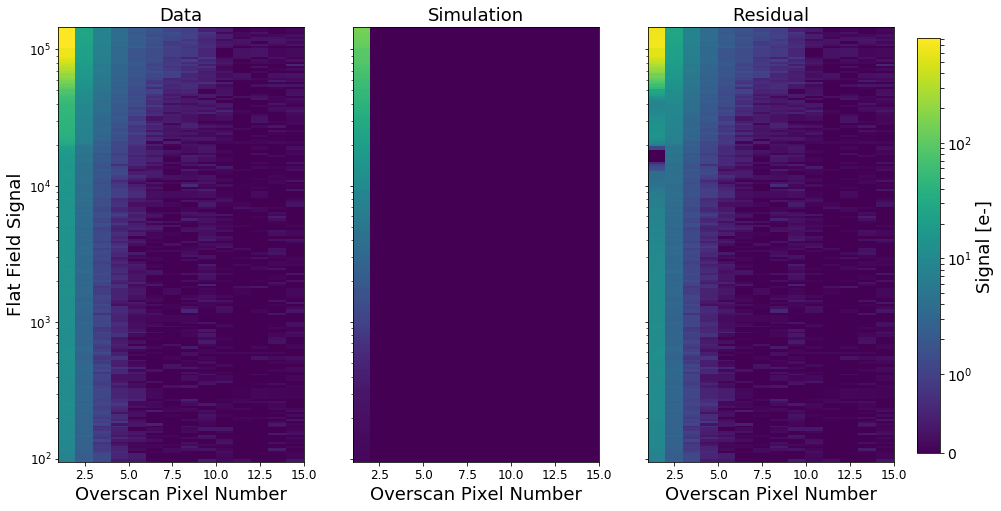

In [2]:
raft_name = 'R02'
ccd_name = 'S02'
sensor_id = '{0}_{1}'.format(raft_name, ccd_name)

param_results = OverscanParameterResults.from_fits(join(main_dir, raft_name, ccd_name, 
                                                        '{0}_parameter_results.fits'.format(sensor_id)))
infile = join(main_dir, raft_name, ccd_name, '{0}_overscan_results.fits'.format(sensor_id))
hdulist = fits.open(infile)
max_signal = 150000.
error = 7.2/np.sqrt(2000.)

start = 1
stop = 15
num_transfers = 512

amp = 9

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
params = Parameters()
params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=True)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)

## Setting up PColor plot
vmin = 0.0
vmax = np.max(data)
y=signals
x=np.arange(start, stop+1)
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, data, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, model, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im2 = axes[2].pcolor(X, Y, data-model,
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_title('Data', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Simulation', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[2].set_title('Residual', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14)

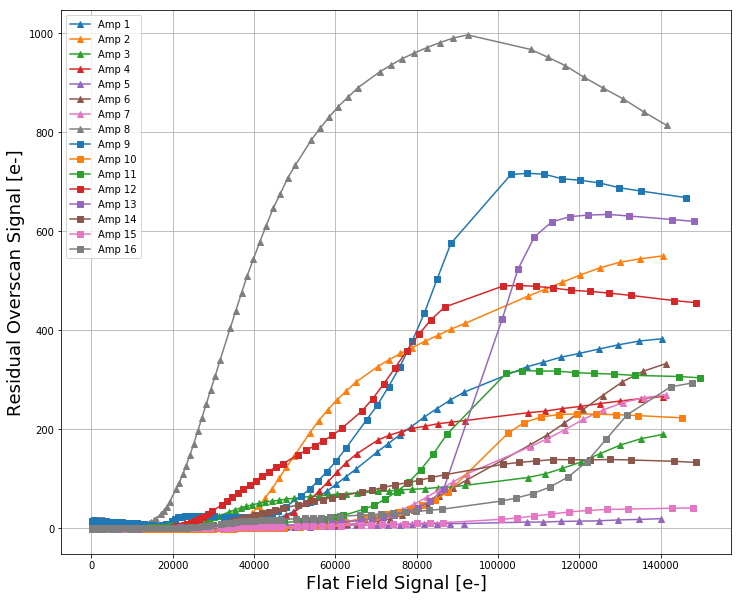

In [3]:
spltraps = {}

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.get_cmap("tab10")
for amp in range(1, 17):
    
    if amp > 8: marker='s'
    else: marker = '^'
    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    ## Model
    params = Parameters()
    params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=True)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
    model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)
    
    res = np.sum((data-model)[:, :3], axis=1)
    
    ax.plot(signals, res, label='Amp {0}'.format(amp), marker=marker, color = cmap((amp-1)%8))
    
    x = signals
    y = res
    # Pad left with ramp
    y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
    x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

    # Pad right with constant
    y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
    x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

    f = interp.interp1d(x, y)
    spltraps[amp] = SplineTrap(f, 0.4, 1)
    pickle.dump(spltraps[amp], open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'wb'))

ax.legend()
ax.set_ylabel('Residual Overscan Signal [e-]', fontsize=18)
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.grid(which='both', axis='both')

## Correction

In [4]:
## Get spline
raft_name = 'R02'
ccd_name = 'S02'
sensor_id = '{0}_{1}'.format(raft_name, ccd_name)
amp = 1
pickle.load(open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'rb'))

## Get electronics
param_results = OverscanParameterResults.from_fits(join(main_dir, raft_name, ccd_name, 
                                                        '{0}_parameter_results.fits'.format(sensor_id)))

cti_results = param_results.cti_results
drift_scales = param_results.drift_scales
decay_times = param_results.decay_times
thresholds = param_results.thresholds
print(cti_results)
print(drift_scales)

{1: 4.380591e-07, 2: 6.3274217e-07, 3: 1.0898464e-06, 4: 7.7181943e-07, 5: 7.105179e-07, 6: 5.8464656e-07, 7: 3.7930295e-07, 8: 8.097616e-06, 9: 2.0932428e-06, 10: 6.0630697e-07, 11: 7.6456223e-07, 12: 6.3798876e-07, 13: 7.291024e-07, 14: 7.134694e-07, 15: 6.372703e-07, 16: 4.575973e-07}
{1: 0.00018251638, 2: 0.0001614502, 3: 0.00016515308, 4: 0.00016774506, 5: 0.00017723533, 6: 0.00017061937, 7: 0.00014561212, 8: 0.00013182026, 9: 0.0, 10: 0.00017524442, 11: 0.0001632896, 12: 0.00016004931, 13: 0.00015891776, 14: 0.00019716594, 15: 0.00016894136, 16: 0.00015324038}


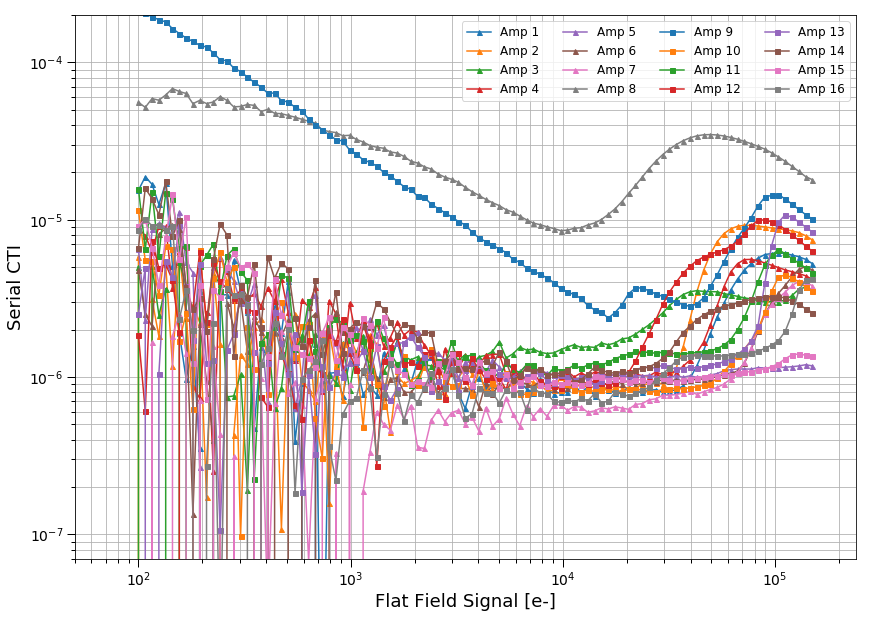

In [5]:
signals = np.logspace(2, np.log10(150000.), 100)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
cmap = plt.get_cmap("tab10")
for amp in range(1, 17):
    imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))
    
    spltrap = pickle.load(open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'rb'))
    if amp > 8: marker='s'
    else: marker = '^'

    ## Simulate ramp readout
    if drift_scales[amp] > 0.:
        output_amplifier = FloatingOutputAmplifier(1.0, drift_scales[amp], decay_times[amp], thresholds[amp],
                                                   noise=7.2/np.sqrt(2000.))
    else:
        output_amplifier = BaseOutputAmplifier(1.0, noise=7.2/np.sqrt(2000.))
        
    ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti_results[amp],
                            traps=spltrap)
    ramp.ramp_exp(signals)
    model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                                 parallel_overscan_width=0)

    cti = (model_results[:, 512])/(512*model_results[:, 511])
    ax.plot(signals, cti, label='Amp {0}'.format(amp), 
            color = cmap((amp-1)%8), marker=marker, markersize=5)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=4, width=1)
ax.set_ylim(bottom=7E-8, top=2E-4)
ax.set_xlim(left=50.0, right=240000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', axis='both')
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_ylabel('Serial CTI', fontsize=18)
ax.legend(fontsize=12, loc=1, ncol=4)